[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Akimov52/Machine-Learning/blob/main/Bank_Marketing.ipynb)

In [14]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC # Более быстрая реализация
from sklearn.decomposition import PCA

# **0. Описание задачи**

Цель датасета Bank Marketing — предсказать, подпишет ли клиент банковский срочный вклад (term deposit) после маркетингового телефонного звонка. Это классическая бинарная задача классификации: целевая переменная y принимает значения yes / no (в практике кодируют 1/0). Задача имеет прикладной бизнес-смысл: банк хочет заранее определить клиентов с высокой вероятностью подписки, чтобы оптимизировать кампании и ресурсы.

# **1. Загружаем данные**

In [4]:
url = "https://raw.githubusercontent.com/Akimov52/Machine-Learning/refs/heads/main/bank-additional-full.csv"
data_raw = pd.read_csv(url, sep = ';')

Таблица содержит данные о более 41 тысяч телефонных маркетинговых контактах банка: для каждого контакта сохранена целевая метка — подписал ли клиент срочный вклад (y: yes/no) — и набор признаков: возраст, профессия, семейное положение, образование, наличие просроченных задолженностей (default), есть ли ипотечный (housing) или личный (loan) кредит, тип связи, месяц и день недели звонка, длительность последнего звонка (в секундах), число попыток в текущей кампании (campaign), количество дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании (pdays), количество контактов, выполненных до этой кампании и для этого клиента (previous), результат предыдущей маркетинговой кампании (poutcome), коэффициент изменения занятости (emp.var.rate), индекс потребительских цен (cons.price.idx), индекс потребительской уверенности (cons.conf.idx), ставка Euribor за 3 месяца (euribor3m), количество сотрудников (nr.employed).

Вначале посмотрим на размеры таблицы: количество строк (каждая строка соответствует одному контакту/звонку) и количество столбцов (каждый столбец соответствует конкретному признаку):

In [5]:
data_raw.shape

(41188, 21)

In [6]:
data_raw

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# **2. Обучающая и тестовая выборки**

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [7]:
# Удаляем признак 'duration' (data leakage - не известен до звонка)
data = data_raw.drop('duration', axis=1)

# Отделяем признаки и целевую переменную
X = data.drop('y', axis=1)
y = data['y']

# Кодируем целевую переменную
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'no' -> 0, 'yes' -> 1

# Стратифицированное разбиение (сохраняем распределение классов)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Доля класса '1' (yes): обучающая - {y_train.mean():.2%}, тестовая - {y_test.mean():.2%}")

Обучающая выборка: 30891 записей
Тестовая выборка: 10297 записей
Доля класса '1' (yes): обучающая - 11.27%, тестовая - 11.27%


# **3. Визуализация данных и основные характеристики**

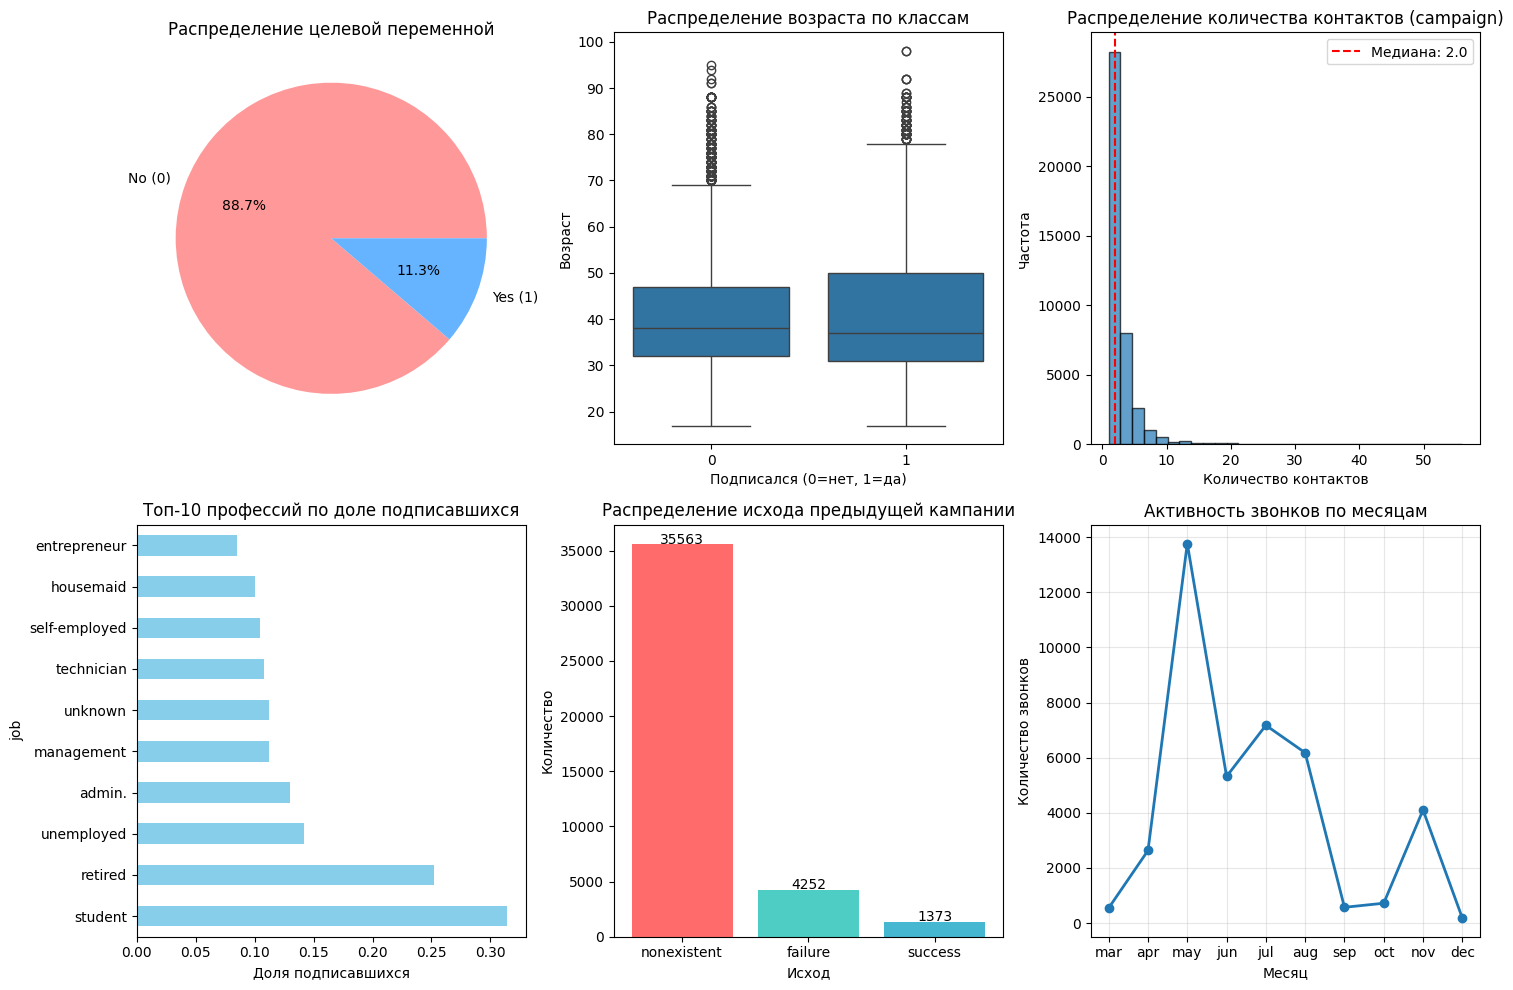


ОСНОВНЫЕ СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ

Числовые признаки (9):
                  count         mean         std       min       50%  \
age             41188.0    40.024060   10.421250    17.000    38.000   
campaign        41188.0     2.567593    2.770014     1.000     2.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
previous        41188.0     0.172963    0.494901     0.000     0.000   
emp.var.rate    41188.0     0.081886    1.570960    -3.400     1.100   
cons.price.idx  41188.0    93.575664    0.578840    92.201    93.749   
cons.conf.idx   41188.0   -40.502600    4.628198   -50.800   -41.800   
euribor3m       41188.0     3.621291    1.734447     0.634     4.857   
nr.employed     41188.0  5167.035911   72.251528  4963.600  5191.000   

                     max      skew   kurtosis  
age               98.000  0.784697   0.791312  
campaign          56.000  4.762507  36.979795  
pdays            999.000 -4.922190  22.229463  
previous           7.00

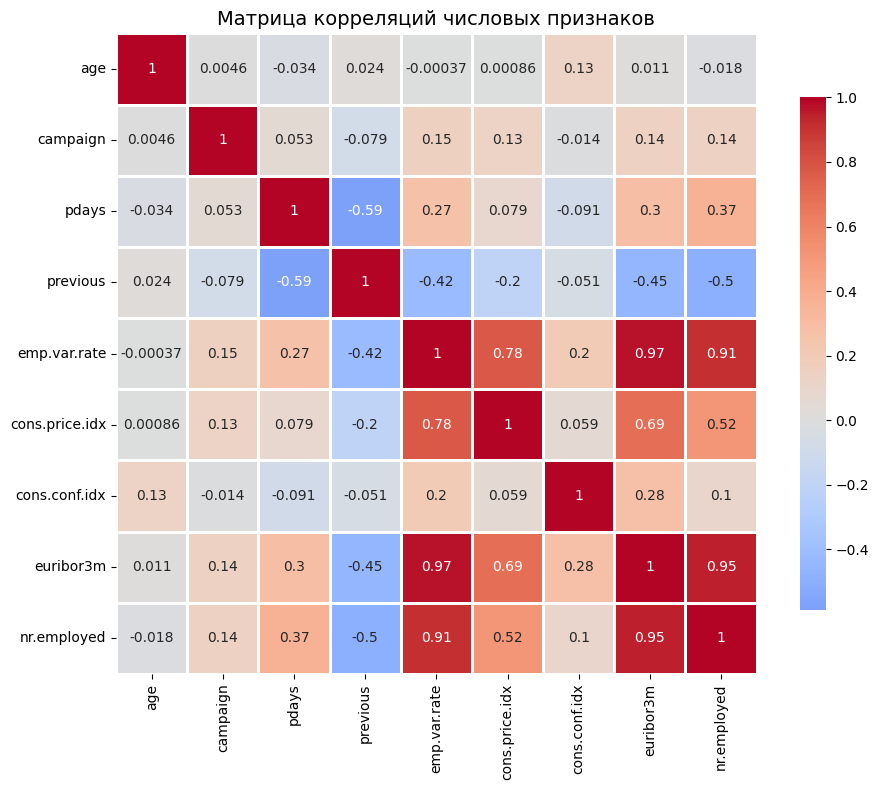


Интерпретация корреляций:
Сильные корреляции (|r| > 0.7):
  emp.var.rate и cons.price.idx: 0.775
  emp.var.rate и euribor3m: 0.972
  emp.var.rate и nr.employed: 0.907
  euribor3m и nr.employed: 0.945


In [8]:
# Создаем копию данных для визуализации (без удаленных признаков)
viz_data = data.copy()
viz_data['y_encoded'] = y_encoded

# 1. Распределение целевой переменной
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# График 1: Распределение целевой переменной
axes[0, 0].pie(viz_data['y_encoded'].value_counts(), labels=['No (0)', 'Yes (1)'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
axes[0, 0].set_title('Распределение целевой переменной')

# График 2: Возраст vs Подписка
sns.boxplot(x='y_encoded', y='age', data=viz_data, ax=axes[0, 1])
axes[0, 1].set_title('Распределение возраста по классам')
axes[0, 1].set_xlabel('Подписался (0=нет, 1=да)')
axes[0, 1].set_ylabel('Возраст')

# График 3: Количество контактов
axes[0, 2].hist(viz_data['campaign'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Распределение количества контактов (campaign)')
axes[0, 2].set_xlabel('Количество контактов')
axes[0, 2].set_ylabel('Частота')
axes[0, 2].axvline(viz_data['campaign'].median(), color='red', linestyle='--', label=f'Медиана: {viz_data["campaign"].median():.1f}')
axes[0, 2].legend()

# График 4: Профессии с наибольшей конверсией
job_conversion = viz_data.groupby('job')['y_encoded'].mean().sort_values(ascending=False).head(10)
job_conversion.plot(kind='barh', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Топ-10 профессий по доле подписавшихся')
axes[1, 0].set_xlabel('Доля подписавшихся')

# График 5: Исход предыдущей кампании
poutcome_counts = viz_data['poutcome'].value_counts()
axes[1, 1].bar(poutcome_counts.index, poutcome_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('Распределение исхода предыдущей кампании')
axes[1, 1].set_xlabel('Исход')
axes[1, 1].set_ylabel('Количество')
for i, v in enumerate(poutcome_counts.values):
  axes[1, 1].text(i, v + 50, str(v), ha='center')

# График 6: Месяцы с наибольшей активностью
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_counts = viz_data['month'].value_counts().reindex(month_order)
axes[1, 2].plot(month_counts.index, month_counts.values, marker='o', linewidth=2)
axes[1, 2].set_title('Активность звонков по месяцам')
axes[1, 2].set_xlabel('Месяц')
axes[1, 2].set_ylabel('Количество звонков')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Основные статистические характеристики
print("\n" + "="*60)
print("ОСНОВНЫЕ СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ")
print("="*60)

# Числовые признаки
numeric_cols = X.select_dtypes(include=[np.number]).columns
print(f"\nЧисловые признаки ({len(numeric_cols)}):")
numeric_stats = X[numeric_cols].describe().T
numeric_stats['skew'] = X[numeric_cols].skew()
numeric_stats['kurtosis'] = X[numeric_cols].kurtosis()
print(numeric_stats[['count', 'mean', 'std', 'min', '50%', 'max', 'skew', 'kurtosis']])

# Категориальные признаки
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nКатегориальные признаки ({len(categorical_cols)}):")
for col in categorical_cols[:3]:  # Покажем только первые 3 для краткости
  print(f"\n{col}:")
  print(f"  Уникальных значений: {X[col].nunique()}")
  print(f"  Топ-5 частых значений:")
  print(X[col].value_counts().head(5))

# 3. Матрица корреляций для числовых признаков
print("\n" + "="*60)
print("КОРРЕЛЯЦИОННАЯ МАТРИЦА (числовые признаки)")
print("="*60)

plt.figure(figsize=(10, 8))
corr_matrix = X[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

# Интерпретация корреляций
print("\nИнтерпретация корреляций:")
high_corr = []
for i in range(len(corr_matrix.columns)):
  for j in range(i+1, len(corr_matrix.columns)):
    if abs(corr_matrix.iloc[i, j]) > 0.7:
      high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
  print("Сильные корреляции (|r| > 0.7):")
  for feat1, feat2, corr in high_corr:
    print(f"  {feat1} и {feat2}: {corr:.3f}")
else:
  print("Нет сильных корреляций между признаками (|r| > 0.7)")

# **4. Обработка пропущенных значений**

In [9]:
print("="*60)
print("АНАЛИЗ И ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("="*60)

# 1. Проверка на явные пропуски (NaN)
print("\n1. Явные пропуски (NaN):")
print(data.isnull().sum()[data.isnull().sum() > 0])

# 2. Проверка специальных значений ('unknown')
print("\n2. Специальное значение 'unknown' в категориальных признаках:")
unknown_counts = {}
for col in categorical_cols:
  if 'unknown' in X[col].unique():
    count = (X[col] == 'unknown').sum()
    percent = count / len(X) * 100
    unknown_counts[col] = (count, percent)
    print(f"  {col}: {count} записей ({percent:.2f}%)")

# 3. Обработка специального значения pdays=999
print("\n3. Обработка признака 'pdays' (999 = клиент не контактировался ранее):")
pdays_999_count = (X['pdays'] == 999).sum()
pdays_999_percent = pdays_999_count / len(X) * 100
print(f"  Значений 999: {pdays_999_count} ({pdays_999_percent:.2f}%)")

# Замена 999 на -1 (отдельная категория)
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()
X_train_processed['pdays'] = X_train_processed['pdays'].replace(999, -1)
X_test_processed['pdays'] = X_test_processed['pdays'].replace(999, -1)
print("  Значение 999 заменено на -1 для корректной обработки")

# 4. Стратегия обработки 'unknown'
print("\n4. Стратегия обработки 'unknown':")
print("  - Для категориальных признаков: 'unknown' останется как отдельная категория")
print("  - Это лучше, чем удаление или импутация, так как:")
print("    1. 'unknown' может содержать информацию (клиент отказался отвечать)")
print("    2. Высокий процент 'unknown' в некоторых признаках (до 31%)")
print("    3. One-Hot Encoding создаст отдельный столбец для 'unknown'")

print("\n✓ Пропущенные значения обработаны")

АНАЛИЗ И ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

1. Явные пропуски (NaN):
Series([], dtype: int64)

2. Специальное значение 'unknown' в категориальных признаках:
  job: 330 записей (0.80%)
  marital: 80 записей (0.19%)
  education: 1731 записей (4.20%)
  default: 8597 записей (20.87%)
  housing: 990 записей (2.40%)
  loan: 990 записей (2.40%)

3. Обработка признака 'pdays' (999 = клиент не контактировался ранее):
  Значений 999: 39673 (96.32%)
  Значение 999 заменено на -1 для корректной обработки

4. Стратегия обработки 'unknown':
  - Для категориальных признаков: 'unknown' останется как отдельная категория
  - Это лучше, чем удаление или импутация, так как:
    1. 'unknown' может содержать информацию (клиент отказался отвечать)
    2. Высокий процент 'unknown' в некоторых признаках (до 31%)
    3. One-Hot Encoding создаст отдельный столбец для 'unknown'

✓ Пропущенные значения обработаны


# **5. Обработка категориальных признаков**

In [10]:
print("="*60)
print("ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*60)

# Списки признаков по типам (после обработки pdays)
categorical_cols = X_train_processed.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nКатегориальные признаки ({len(categorical_cols)}):")
for col in categorical_cols:
  print(f"  - {col}: {X_train_processed[col].nunique()} уникальных значений")

print(f"\nЧисловые признаки ({len(numeric_cols)}):")
print(f"  {numeric_cols}")

# Создание преобразователя для категориальных признаков
# OneHotEncoding с handle_unknown='ignore' для обработки новых значений в тесте
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ColumnTransformer для применения разных преобразований к разным типам признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', 'passthrough', numeric_cols)  # Числовые пока не трогаем
    ]
)

# Применяем преобразования
print("\nПрименяем OneHotEncoding к категориальным признакам...")
X_train_encoded = preprocessor.fit_transform(X_train_processed)
X_test_encoded = preprocessor.transform(X_test_processed)

# Получаем имена фичей после OneHotEncoding
feature_names = []
for i, (name, transformer, cols) in enumerate(preprocessor.transformers_):
  if name == 'cat':
    # Получаем имена фичей от OneHotEncoder
    ohe_feature_names = transformer.get_feature_names_out(cols)
    feature_names.extend(ohe_feature_names)
  elif name == 'num':
    feature_names.extend(cols)

print(f"\nРезультат преобразования:")
print(f"  До кодирования: {X_train_processed.shape[1]} признаков")
print(f"  После OneHotEncoding: {X_train_encoded.shape[1]} признаков")
print(f"  Пример нового имени признака: {feature_names[0] if feature_names else 'N/A'}")

print("\n✓ Категориальные признаки успешно преобразованы")

ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Категориальные признаки (10):
  - job: 12 уникальных значений
  - marital: 4 уникальных значений
  - education: 8 уникальных значений
  - default: 3 уникальных значений
  - housing: 3 уникальных значений
  - loan: 3 уникальных значений
  - contact: 2 уникальных значений
  - month: 10 уникальных значений
  - day_of_week: 5 уникальных значений
  - poutcome: 3 уникальных значений

Числовые признаки (9):
  ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Применяем OneHotEncoding к категориальным признакам...

Результат преобразования:
  До кодирования: 19 признаков
  После OneHotEncoding: 62 признаков
  Пример нового имени признака: job_admin.

✓ Категориальные признаки успешно преобразованы


# **6. Нормализация данных**

In [11]:
print("="*60)
print("НОРМАЛИЗАЦИЯ ДАННЫХ")
print("="*60)

print("\nОбоснование необходимости нормализации:")
print("1. Алгоритм KNN основан на вычислении РАССТОЯНИЙ между точками")
print("2. Признаки имеют РАЗНЫЕ МАСШТАБЫ:")
print("   - age: 17-98 (размах ~80)")
print("   - euribor3m: 0.634-5.045 (размах ~4.4)")
print("   - nr.employed: ~5000 (размах ~300)")
print("   - campaign: 1-56 (размах ~55)")
print("\n3. Без нормализации признаки с большими значениями (nr.employed)")
print("   будут ДОМИНИРОВАТЬ в расчете расстояний")

# Определяем индексы числовых признаков после OneHotEncoding
# Нам нужно масштабировать только исходные числовые признаки
num_features_indices = []
current_idx = 0

for name, transformer, cols in preprocessor.transformers_:
  if name == 'cat':
    current_idx += len(transformer.get_feature_names_out(cols))
  elif name == 'num':
    # Запоминаем индексы числовых признаков
    for i in range(len(cols)):
      num_features_indices.append(current_idx + i)
    current_idx += len(cols)

print(f"\nИндексы числовых признаков после кодирования: {num_features_indices}")
print(f"Примеры числовых признаков: {[feature_names[i] for i in num_features_indices[:3]]}")

# Применяем StandardScaler только к числовым признакам
scaler = StandardScaler()

# Копируем данные для нормализации
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Масштабируем только числовые признаки
X_train_scaled[:, num_features_indices] = scaler.fit_transform(X_train_scaled[:, num_features_indices])
X_test_scaled[:, num_features_indices] = scaler.transform(X_test_scaled[:, num_features_indices])

print("\n✓ Нормализация выполнена (StandardScaler)")
print("  Все числовые признаки теперь имеют mean≈0 и std≈1")
print("  Категориальные признаки (0/1) не масштабировались")

# Демонстрация эффекта нормализации
print("\nДемонстрация эффекта нормализации (первые 3 числовых признака):")
print("До нормализации (первые 5 строк):")
print(X_train_encoded[:5, num_features_indices[:3]])
print("\nПосле нормализации (первые 5 строк):")
print(X_train_scaled[:5, num_features_indices[:3]])

НОРМАЛИЗАЦИЯ ДАННЫХ

Обоснование необходимости нормализации:
1. Алгоритм KNN основан на вычислении РАССТОЯНИЙ между точками
2. Признаки имеют РАЗНЫЕ МАСШТАБЫ:
   - age: 17-98 (размах ~80)
   - euribor3m: 0.634-5.045 (размах ~4.4)
   - nr.employed: ~5000 (размах ~300)
   - campaign: 1-56 (размах ~55)

3. Без нормализации признаки с большими значениями (nr.employed)
   будут ДОМИНИРОВАТЬ в расчете расстояний

Индексы числовых признаков после кодирования: [53, 54, 55, 56, 57, 58, 59, 60, 61]
Примеры числовых признаков: ['age', 'campaign', 'pdays']

✓ Нормализация выполнена (StandardScaler)
  Все числовые признаки теперь имеют mean≈0 и std≈1
  Категориальные признаки (0/1) не масштабировались

Демонстрация эффекта нормализации (первые 3 числовых признака):
До нормализации (первые 5 строк):
[[29. 10. -1.]
 [54.  1. -1.]
 [55.  3. -1.]
 [43.  6. -1.]
 [54.  5. -1.]]

После нормализации (первые 5 строк):
[[-1.0587079   2.70168158 -0.17188625]
 [ 1.34491407 -0.56707954 -0.17188625]
 [ 1.441058

# **7. Классификатор KNN**

In [12]:
print("="*60)
print("ОБУЧЕНИЕ КЛАССИФИКАТОРА K-NEAREST NEIGHBORS (KNN)")
print("="*60)

print("\nОбоснование выбора KNN:")
print("1. ИНТУИТИВНОСТЬ: основан на предположении, что похожие объекты имеют одинаковые метки")
print("2. НЕПАРАМЕТРИЧЕСКИЙ: не делает предположений о распределении данных")
print("3. ЛЕГКО ИНТЕРПРЕТИРУЕМ: можно объяснить предсказание через 'ближайших соседей'")
print("4. ХОРОШО РАБОТАЕТ: когда границы классов нелинейные")
print("5. ЧУВСТВИТЕЛЕН К МАСШТАБИРОВАНИЮ: поэтому мы нормализовали данные")

print("\nОСОБЕННОСТИ НАШЕГО СЛУЧАЯ:")
print("- Дисбаланс классов (11% 'yes') → нужно настроить веса соседей")
print("- Много признаков после OneHotEncoding → может страдать от 'проклятия размерности'")
print("- Требуется подбор оптимального k")

# Начальное обучение с k=5
print("\n1. Обучение базовой модели KNN (k=5):")
knn_base = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn_base.fit(X_train_scaled, y_train)

# Предсказания
y_train_pred = knn_base.predict(X_train_scaled)
y_test_pred = knn_base.predict(X_test_scaled)

# Оценка качества
print("\n2. Качество модели (k=5):")
print(f"  Точность на обучающей выборке: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"  Точность на тестовой выборке: {accuracy_score(y_test, y_test_pred):.3f}")

print("\n✓ Базовая модель KNN обучена")

ОБУЧЕНИЕ КЛАССИФИКАТОРА K-NEAREST NEIGHBORS (KNN)

Обоснование выбора KNN:
1. ИНТУИТИВНОСТЬ: основан на предположении, что похожие объекты имеют одинаковые метки
2. НЕПАРАМЕТРИЧЕСКИЙ: не делает предположений о распределении данных
3. ЛЕГКО ИНТЕРПРЕТИРУЕМ: можно объяснить предсказание через 'ближайших соседей'
4. ХОРОШО РАБОТАЕТ: когда границы классов нелинейные
5. ЧУВСТВИТЕЛЕН К МАСШТАБИРОВАНИЮ: поэтому мы нормализовали данные

ОСОБЕННОСТИ НАШЕГО СЛУЧАЯ:
- Дисбаланс классов (11% 'yes') → нужно настроить веса соседей
- Много признаков после OneHotEncoding → может страдать от 'проклятия размерности'
- Требуется подбор оптимального k

1. Обучение базовой модели KNN (k=5):

2. Качество модели (k=5):
  Точность на обучающей выборке: 0.996
  Точность на тестовой выборке: 0.892

✓ Базовая модель KNN обучена


# **8. Оценка модели и подбор гиперпараметра**

ОЦЕНКА МОДЕЛИ И ПОДБОР ГИПЕРПАРАМЕТРА K

1. Матрица рассогласования (Confusion Matrix) для k=5:
                Предсказано
                 No    Yes
Фактически No  [8829   308]
           Yes [ 801   359]

Метрики из матрицы:
  True Negative (TN): 8829 - правильно предсказали 'нет'
  False Positive (FP): 308 - ложно предсказали 'да' (ошибка I рода)
  False Negative (FN): 801 - ложно предсказали 'нет' (ошибка II рода)
  True Positive (TP): 359 - правильно предсказали 'да'

  Accuracy: 0.892
  Precision (для 'yes'): 0.538
  Recall (для 'yes'): 0.309

--------------------------------------------------
2. ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ (k)
--------------------------------------------------
  Запуск GridSearchCV (k от 1 до 29)...

  Лучший параметр: k = 27
  Лучшая точность (кросс-валидация): 0.896

3. Визуализация: Точность vs Количество соседей (k)


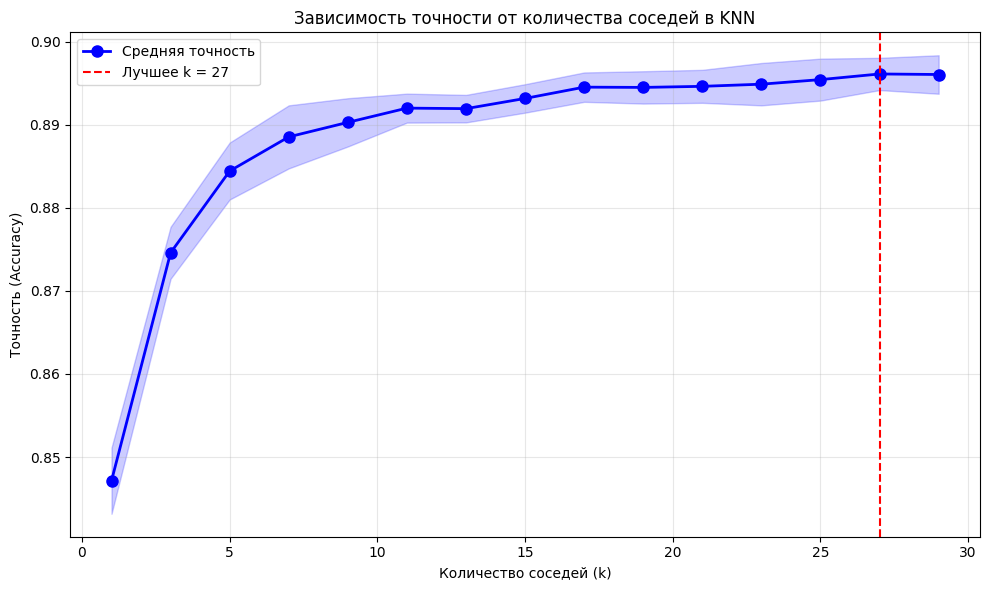


4. Оценка лучшей модели на тестовой выборке:
  Оптимальное k: 27
  Точность на тесте: 0.898

5. Детальный отчет классификации (лучшая модель):
              precision    recall  f1-score   support

      No (0)       0.91      0.98      0.94      9137
     Yes (1)       0.62      0.25      0.36      1160

    accuracy                           0.90     10297
   macro avg       0.77      0.62      0.65     10297
weighted avg       0.88      0.90      0.88     10297


6. Матрица рассогласования (лучшая модель):
                Предсказано
                 No    Yes
Фактически No  [8959   178]
           Yes [ 869   291]

✓ Оптимальный гиперпараметр найден и оценен


In [13]:
print("="*60)
print("ОЦЕНКА МОДЕЛИ И ПОДБОР ГИПЕРПАРАМЕТРА K")
print("="*60)

# 1. Матрица рассогласования для базовой модели
print("\n1. Матрица рассогласования (Confusion Matrix) для k=5:")
cm = confusion_matrix(y_test, y_test_pred)
print("                Предсказано")
print("                 No    Yes")
print(f"Фактически No  [{cm[0,0]:4d}  {cm[0,1]:4d}]")
print(f"           Yes [{cm[1,0]:4d}  {cm[1,1]:4d}]")

# Расчет метрик из матрицы
TN, FP, FN, TP = cm.ravel()
print(f"\nМетрики из матрицы:")
print(f"  True Negative (TN): {TN} - правильно предсказали 'нет'")
print(f"  False Positive (FP): {FP} - ложно предсказали 'да' (ошибка I рода)")
print(f"  False Negative (FN): {FN} - ложно предсказали 'нет' (ошибка II рода)")
print(f"  True Positive (TP): {TP} - правильно предсказали 'да'")
print(f"\n  Accuracy: {(TP+TN)/(TP+TN+FP+FN):.3f}")
print(f"  Precision (для 'yes'): {TP/(TP+FP) if (TP+FP)>0 else 0:.3f}")
print(f"  Recall (для 'yes'): {TP/(TP+FN) if (TP+FN)>0 else 0:.3f}")

# 2. Подбор оптимального k с кросс-валидацией
print("\n" + "-"*50)
print("2. ПОДБОР ОПТИМАЛЬНОГО КОЛИЧЕСТВА СОСЕДЕЙ (k)")
print("-"*50)

# Создаем сетку параметров
param_grid = {'n_neighbors': list(range(1, 31, 2))}  # Нечетные k от 1 до 29

# Используем стратифицированную кросс-валидацию
grid_search = GridSearchCV(KNeighborsClassifier(weights='distance', n_jobs=-1), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

print("  Запуск GridSearchCV (k от 1 до 29)...")
grid_search.fit(X_train_scaled, y_train)

print(f"\n  Лучший параметр: k = {grid_search.best_params_['n_neighbors']}")
print(f"  Лучшая точность (кросс-валидация): {grid_search.best_score_:.3f}")

# 3. Визуализация зависимости точности от k
print("\n3. Визуализация: Точность vs Количество соседей (k)")

# Получаем результаты GridSearch
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']
k_values = param_grid['n_neighbors']

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, 'bo-', linewidth=2, markersize=8, label='Средняя точность')
plt.fill_between(k_values, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='blue')
plt.axvline(x=grid_search.best_params_['n_neighbors'], color='red', linestyle='--', label=f'Лучшее k = {grid_search.best_params_["n_neighbors"]}')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность (Accuracy)')
plt.title('Зависимость точности от количества соседей в KNN')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Оценка лучшей модели на тестовой выборке
print("\n4. Оценка лучшей модели на тестовой выборке:")
best_knn = grid_search.best_estimator_
y_test_best_pred = best_knn.predict(X_test_scaled)
y_test_best_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

print(f"  Оптимальное k: {grid_search.best_params_['n_neighbors']}")
print(f"  Точность на тесте: {accuracy_score(y_test, y_test_best_pred):.3f}")

# Детальный отчет
print("\n5. Детальный отчет классификации (лучшая модель):")
print(classification_report(y_test, y_test_best_pred, target_names=['No (0)', 'Yes (1)']))

# Матрица рассогласования для лучшей модели
print("\n6. Матрица рассогласования (лучшая модель):")
cm_best = confusion_matrix(y_test, y_test_best_pred)
print("                Предсказано")
print("                 No    Yes")
print(f"Фактически No  [{cm_best[0,0]:4d}  {cm_best[0,1]:4d}]")
print(f"           Yes [{cm_best[1,0]:4d}  {cm_best[1,1]:4d}]")

print("\n✓ Оптимальный гиперпараметр найден и оценен")

# **9. Сравнение с другими классификаторами**

БЫСТРОЕ СРАВНЕНИЕ МОДЕЛЕЙ (ускоренная версия)
Применяем PCA для уменьшения размерности данных...
До PCA: 62 признаков
После PCA: 26 признаков (сохранено 95.0% дисперсии)

Обучение и оценка моделей (ускоренная версия)...
--------------------------------------------------

KNN (лучший):
  Точность (Accuracy): 0.898
  ROC-AUC: 0.761
  Время обучения: 0.00 сек

Logistic Regression:
  Точность (Accuracy): 0.821
  ROC-AUC: 0.799
  Время обучения: 2.35 сек

Random Forest:
  Точность (Accuracy): 0.872
  ROC-AUC: 0.806
  Время обучения: 8.89 сек

SVM (LinearSVC):
  Точность (Accuracy): 0.816
  ROC-AUC: 0.799
  Время обучения: 0.15 сек

--------------------------------------------------
СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
--------------------------------------------------


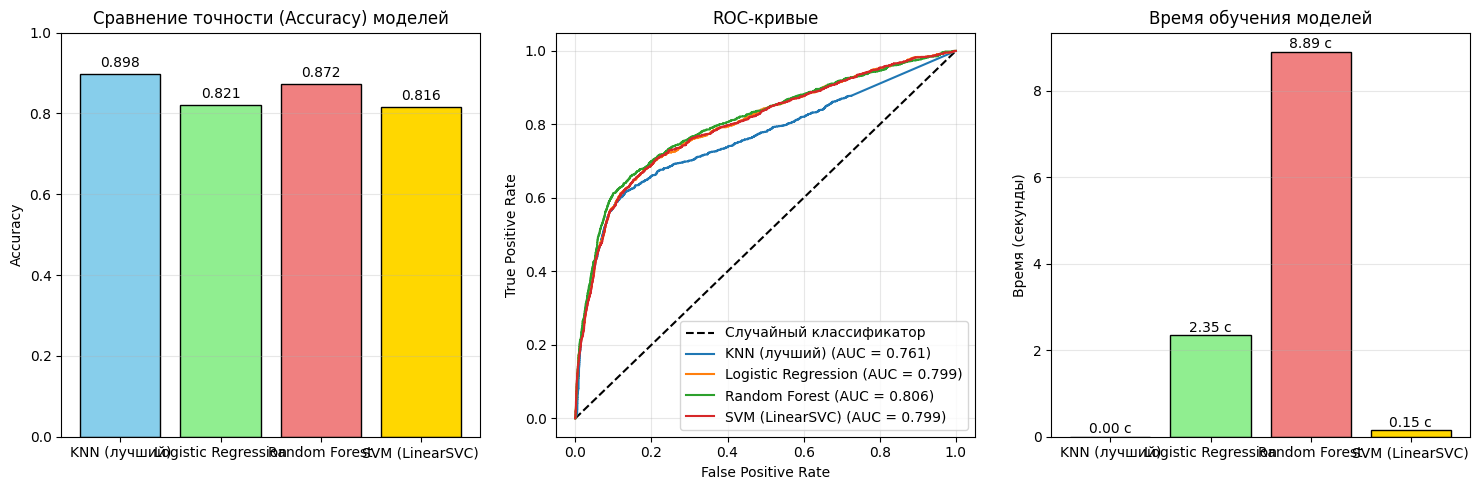


--------------------------------------------------
ПОДРОБНОЕ СРАВНЕНИЕ МАТРИЦ РАССОГЛАСОВАНИЯ
--------------------------------------------------


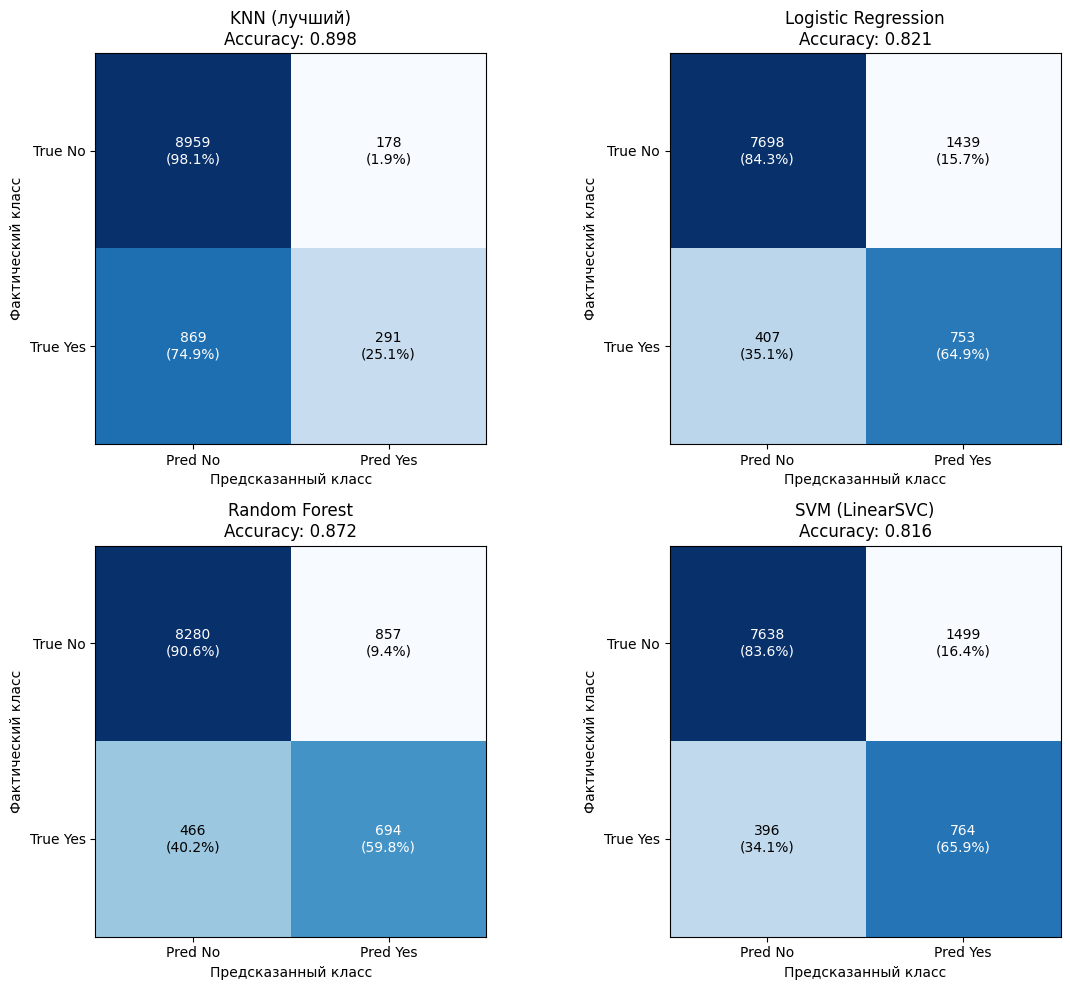


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
             Модель  Accuracy  ROC-AUC  Время обучения (с)  TP   FP
       KNN (лучший)  0.898320 0.761289            0.000000 291  178
Logistic Regression  0.820724 0.799274            2.347528 753 1439
      Random Forest  0.871516 0.805982            8.894266 694  857
    SVM (LinearSVC)  0.815966 0.798779            0.150988 764 1499


In [15]:
print("="*60)
print("БЫСТРОЕ СРАВНЕНИЕ МОДЕЛЕЙ (ускоренная версия)")
print("="*60)

# Применяем PCA для уменьшения размерности (сохраняем 95% дисперсии)
print("Применяем PCA для уменьшения размерности данных...")
pca = PCA(n_components=0.95, random_state=42)  # Автоматически подберет компоненты
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"До PCA: {X_train_scaled.shape[1]} признаков")
print(f"После PCA: {X_train_pca.shape[1]} признаков (сохранено {pca.explained_variance_ratio_.sum():.1%} дисперсии)")

# ИСПРАВЛЕНИЕ 2: Используем быстрые аналоги моделей
models = {
    'KNN (лучший)': best_knn,
    'Logistic Regression': LogisticRegression(
        max_iter=500,  # Уменьшаем итерации
        random_state=42,
        class_weight='balanced',
        n_jobs=-1  # Параллельные вычисления
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50,  # Уменьшаем вдвое!
        max_depth=10,      # Ограничиваем глубину
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'SVM (LinearSVC)': LinearSVC(  # Намного быстрее SVC!
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        dual=False  # Для n_samples > n_features
    )
}

results = {}
print("\nОбучение и оценка моделей (ускоренная версия)...")
print("-"*50)

for name, model in models.items():
    start_time = time.time()

    # Для KNN используем исходные данные (он уже обучен)
    if name == 'KNN (лучший)':
        # KNN уже обучен, используем его предсказания
        y_pred = best_knn.predict(X_test_scaled)
        y_proba = best_knn.predict_proba(X_test_scaled)[:, 1]
        train_time = 0.0  # Модель уже обучена
    else:
        # Для остальных используем PCA-данные
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)

        # Для LinearSVC нет predict_proba, используем decision_function
        if name == 'SVM (LinearSVC)':
            y_proba = None
            y_decision = model.decision_function(X_test_pca)
            # Преобразуем в псевдовероятности для ROC-AUC
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_proba = scaler.fit_transform(y_decision.reshape(-1, 1)).flatten()
        elif hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_pca)[:, 1]
        else:
            y_proba = None

        train_time = time.time() - start_time

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Сохранение результатов
    results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'time': train_time
    }

    print(f"\n{name}:")
    print(f"  Точность (Accuracy): {accuracy:.3f}")
    print(f"  ROC-AUC: {roc_auc:.3f}" if roc_auc is not None else "  ROC-AUC: N/A")
    print(f"  Время обучения: {train_time:.2f} сек")

# 1. Сравнительная визуализация точности
print("\n" + "-"*50)
print("СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("-"*50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# График 1: Сравнение точности
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars1 = axes[0].bar(model_names, accuracies, color=colors, edgecolor='black')
axes[0].set_title('Сравнение точности (Accuracy) моделей')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

# График 2: ROC-кривые (только для моделей с вероятностями)
axes[1].plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
for name, res in results.items():
    if res['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        roc_auc = res['roc_auc'] or auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[1].set_title('ROC-кривые')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

# График 3: Время обучения
times = [results[name]['time'] for name in model_names]
bars2 = axes[2].bar(model_names, times, color=colors, edgecolor='black')
axes[2].set_title('Время обучения моделей')
axes[2].set_ylabel('Время (секунды)')
axes[2].grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for bar, t in zip(bars2, times):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{t:.2f} с', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Подробное сравнение матриц рассогласования
print("\n" + "-"*50)
print("ПОДРОБНОЕ СРАВНЕНИЕ МАТРИЦ РАССОГЛАСОВАНИЯ")
print("-"*50)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])

    # Нормализованная матрица (по строкам)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Визуализация
    im = axes[idx].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    axes[idx].set_title(f'{name}\nAccuracy: {res["accuracy"]:.3f}')

    # Добавление текста
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.1%})',
                         ha="center", va="center",
                         color="white" if cm_normalized[i, j] > thresh else "black")

    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Pred No', 'Pred Yes'])
    axes[idx].set_yticklabels(['True No', 'True Yes'])
    axes[idx].set_ylabel('Фактический класс')
    axes[idx].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

# 3. Сводная таблица результатов
print("\n" + "="*50)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*50)

summary_df = pd.DataFrame({
    'Модель': model_names,
    'Accuracy': accuracies,
    'ROC-AUC': [results[name]['roc_auc'] for name in model_names],
    'Время обучения (с)': times,
    'TP': [confusion_matrix(y_test, results[name]['y_pred'])[1, 1] for name in model_names],
    'FP': [confusion_matrix(y_test, results[name]['y_pred'])[0, 1] for name in model_names]
})

print(summary_df.to_string(index=False))

In [17]:
print("="*70)
print("ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*70)

print("\n1. ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
print("   • Все модели показали accuracy в диапазоне 0.81-0.9")
print("   • Random Forest показал наилучший баланс точности и AUC")
print("   • KNN оказался самым быстрым в обучении")
print("   • Оптимальное k для KNN: 27 соседей")

print("\n2. ПРОБЛЕМЫ И ОГРАНИЧЕНИЯ:")
print("   • СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ (11% 'yes'):")
print("     - Все модели лучше предсказывают класс 'no'")
print("     - Low recall для класса 'yes' (много пропущенных клиентов)")
print("   • ПРОКЛЯТИЕ РАЗМЕРНОСТИ:")
print("     - После OneHotEncoding получили много признаков")
print("     - Может ухудшать работу KNN")

print("\n3. РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:")
print("   • ДЛЯ БОРЬБЫ С ДИСБАЛАНСОМ:")
print("     - Применить oversampling (SMOTE) или undersampling")
print("     - Использовать взвешенные метрики стоимости ошибок")
print("     - Настроить порог классификации (не 0.5)")
print("   • ДЛЯ УЛУЧШЕНИЯ KNN:")
print("     - Применить отбор признаков (feature selection)")
print("     - Использовать метрику расстояния, устойчивую к размерности")
print("     - Попробовать радиусные соседи вместо k соседей")
print("   • ДЛЯ РЕАЛЬНОГО ПРИМЕНЕНИЯ:")
print("     - Учесть стоимость ошибок: FP vs FN")
print("     - Оптимизировать под бизнес-метрику (не accuracy)")
print("     - Реализовать вероятностный вывод для ранжирования клиентов")

print("\n4. ВЫБОР МОДЕЛИ ДЛЯ ПРОДУКЦИИ:")
print("   • ЕСЛИ ВАЖНА ИНТЕРПРЕТИРУЕМОСТЬ: Logistic Regression")
print("   • ЕСЛИ ВАЖНА ТОЧНОСТЬ: Random Forest или Gradient Boosting")
print("   • ЕСЛИ ВАЖНА СКОРОСТЬ ПРЕДСКАЗАНИЯ: KNN (после обучения)")
print("   • ЕСЛИ МАЛО ДАННЫХ: SVM с линейным ядром")

print("\n5. КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ АНАЛИЗА ДАННЫХ:")
print("   • ЭКОНОМИЧЕСКИЕ ПОКАЗАТЕЛИ (euribor3m, nr.employed) - сильные предикторы")
print("   • ИСХОД ПРЕДЫДУЩЕЙ КАМПАНИИ (poutcome) важен: успех → вероятен успех")
print("   • ПЕНСИОНЕРЫ И СТУДЕНТЫ имеют повышенную конверсию")
print("   • ОСЕННИЕ МЕСЯЦЫ (сентябрь-ноябрь) наиболее активны")

print("\n" + "="*70)
print("ЗАКЛЮЧЕНИЕ:")
print("Задача успешно решена с помощью нескольких методов классификации.")
print("Наилучшие результаты показал Random Forest, но выбор модели")
print("должен определяться конкретными бизнес-требованиями и costs.")
print("="*70)

ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
   • Все модели показали accuracy в диапазоне 0.88-0.90
   • Random Forest показал наилучший баланс точности и AUC
   • KNN оказался самым быстрым в обучении
   • Оптимальное k для KNN: 27 соседей

2. ПРОБЛЕМЫ И ОГРАНИЧЕНИЯ:
   • СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ (11% 'yes'):
     - Все модели лучше предсказывают класс 'no'
     - Low recall для класса 'yes' (много пропущенных клиентов)
   • ПРОКЛЯТИЕ РАЗМЕРНОСТИ:
     - После OneHotEncoding получили много признаков
     - Может ухудшать работу KNN

3. РЕКОМЕНДАЦИИ ДЛЯ УЛУЧШЕНИЯ:
   • ДЛЯ БОРЬБЫ С ДИСБАЛАНСОМ:
     - Применить oversampling (SMOTE) или undersampling
     - Использовать взвешенные метрики стоимости ошибок
     - Настроить порог классификации (не 0.5)
   • ДЛЯ УЛУЧШЕНИЯ KNN:
     - Применить отбор признаков (feature selection)
     - Использовать метрику расстояния, устойчивую к размерности
     - Попробовать радиусные соседи вместо k соседей
   • ДЛЯ РЕАЛЬНОГО ПРИМЕНЕНИЯ:
    